**Project Introduction: Predicting Sepsis Risk in ICU Patients**

In this machine learning project, our goal is to develop a predictive model that can help healthcare professionals identify whether a patient in the Intensive Care Unit (ICU) is at risk of developing sepsis. Sepsis is a critical condition, and early detection is crucial for timely intervention and improved patient outcomes.

**Dataset Description:**

- **ID:** Unique patient identifier.
- **PRG (Plasma Glucose):** Plasma glucose levels.
- **PL (Blood Work Result-1):** Blood work result 1 (mu U/ml).
- **PR (Blood Pressure):** Blood pressure in mm Hg.
- **SK (Blood Work Result-2):** Blood work result 2 (mm).
- **TS (Blood Work Result-3):** Blood work result 3 (mu U/ml).
- **M11 (Body Mass Index):** Body mass index (weight in kg / (height in m)^2).
- **BD2 (Blood Work Result-4):** Blood work result 4 (mu U/ml).
- **Age:** Patient's age in years.
- **Insurance:** Indicates if the patient holds a valid insurance card.
- **Sepsis (Target):** Binary target variable - Positive if the patient will develop sepsis in the ICU, Negative otherwise.

By utilizing these patient attributes, we aim to create a model that can assist healthcare providers in making informed decisions and potentially saving lives through early sepsis risk detection.

## Questions

1. Is there a difference in plasma glucose levels (PRG) between patients with and without sepsis?
2. How does age vary between patients with and without sepsis?
3. Are there differences in blood pressure (PR) between insured and uninsured patients?
4. Does BMI (M11) differ between insured and uninsured patients?
5. Is there an association between plasma glucose levels (PRG) and blood pressure (PR)?
6. What is the distribution of body mass index (BMI - M11) across different age groups?
7. How does the prevalence of sepsis vary across different age groups?
8. Are there differences in plasma glucose levels (PRG) among patients with different insurance statuses, considering their age?

##  Hypothesis 

Plasma Glucose Levels by Sepsis Status

Blood Pressure by Insurance Status

Age Distribution by Sepsis Status

BMI by Insurance Status

Age Distribution by Insurance Status

## Installation

In [1]:
# !pip install lightgbm
# !pip install catboost
# !pip install python-dotenv
# !pip install xgboost

## Importation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb 
import lightgbm as lgb
import catboost
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import os
import pickle
import shutil


import warnings
warnings.filterwarnings("ignore")


## Data Collection & Loading

In [3]:
df_train = pd.read_csv('Asset\Paitients_Files_Train.csv')

In [4]:
df_train.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,Positive
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,Negative
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,Positive
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,Negative
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,Positive


In [5]:
df_train.shape

(599, 11)

In [6]:
df_train.info

<bound method DataFrame.info of             ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0    ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1    ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2    ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3    ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4    ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive
..         ...  ...  ...  ..  ..  ...   ...    ...  ...        ...       ...
594  ICU200604    6  123  72  45  230  33.6  0.733   34          0  Negative
595  ICU200605    0  188  82  14  185  32.0  0.682   22          1  Positive
596  ICU200606    0   67  76   0    0  45.3  0.194   46          1  Negative
597  ICU200607    1   89  24  19   25  27.8  0.559   21          0  Negative
598  ICU200608    1  173  74   0    0  36.8  0.088   38          1  Positive

[599 rows x 11 columns]>

In [7]:
df_train.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
Sepssis      0
dtype: int64

In [8]:
# Summary statistics for numerical columns
numerical_summary = df_train.describe()
print("\nNumerical Summary:")
print(numerical_summary)


Numerical Summary:
              PRG          PL          PR          SK          TS         M11  \
count  599.000000  599.000000  599.000000  599.000000  599.000000  599.000000   
mean     3.824708  120.153589   68.732888   20.562604   79.460768   31.920033   
std      3.362839   32.682364   19.335675   16.017622  116.576176    8.008227   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   64.000000    0.000000    0.000000   27.100000   
50%      3.000000  116.000000   70.000000   23.000000   36.000000   32.000000   
75%      6.000000  140.000000   80.000000   32.000000  123.500000   36.550000   
max     17.000000  198.000000  122.000000   99.000000  846.000000   67.100000   

              BD2         Age   Insurance  
count  599.000000  599.000000  599.000000  
mean     0.481187   33.290484    0.686144  
std      0.337552   11.828446    0.464447  
min      0.078000   21.000000    0.000000  
25%      0.248000   24.000000 

1. **PRG (Plasma Glucose):**
   - The mean plasma glucose level is approximately 3.82.
   - The standard deviation is relatively high, indicating variability in glucose levels.
   - The minimum value is 0, which may need further investigation.
   - The range of values is from 0 to 17.

2. **PL (Blood Work Result-1):**
   - The mean value for this attribute is about 120.15.
   - The standard deviation suggests some variability in the results.
   - The minimum value is 0, which might be problematic.
   - The range of values is from 0 to 198.

3. **PR (Blood Pressure):**
   - The mean blood pressure is around 68.73 mm Hg.
   - The standard deviation indicates variability in blood pressure readings.
   - The minimum value is 0, which might be problematic.
   - The range of values is from 0 to 122.

4. **SK (Blood Work Result-2):**
   - The mean value for this attribute is approximately 20.56 mm.
   - The standard deviation suggests variability.
   - The minimum value is 0, which could be a concern.
   - The range of values is from 0 to 99.

5. **TS (Blood Work Result-3):**
   - The mean value for this attribute is roughly 79.46 mu U/ml.
   - There is a high standard deviation, indicating a wide spread of values.
   - The minimum value is 0, which might require investigation.
   - The range of values is from 0 to 846.

6. **M11 (Body Mass Index):**
   - The mean BMI is approximately 31.92.
   - The standard deviation is moderate.
   - The minimum value is 0, which could indicate missing or incorrect data.
   - The range of values is from 0 to 67.1.

7. **BD2 (Blood Work Result-4):**
   - The mean value for this attribute is about 0.48 mu U/ml.
   - The standard deviation suggests some variability.
   - The minimum value is 0.078, indicating a narrower range.
   - The range of values is from 0.078 to 2.42.

8. **Insurance:**
   - This binary variable indicates insurance status.
   - The mean value is approximately 0.69, suggesting that a majority of patients have insurance (1) in the dataset.

In [9]:
df_test = pd.read_csv('Asset\Paitients_Files_Test.csv')

In [10]:
df_test

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0
...,...,...,...,...,...,...,...,...,...,...
164,ICU200773,10,101,76,48,180,32.9,0.171,63,1
165,ICU200774,2,122,70,27,0,36.8,0.340,27,1
166,ICU200775,5,121,72,23,112,26.2,0.245,30,1
167,ICU200776,1,126,60,0,0,30.1,0.349,47,1


In [11]:
df_test.isna().sum()

ID           0
PRG          0
PL           0
PR           0
SK           0
TS           0
M11          0
BD2          0
Age          0
Insurance    0
dtype: int64

## EDA

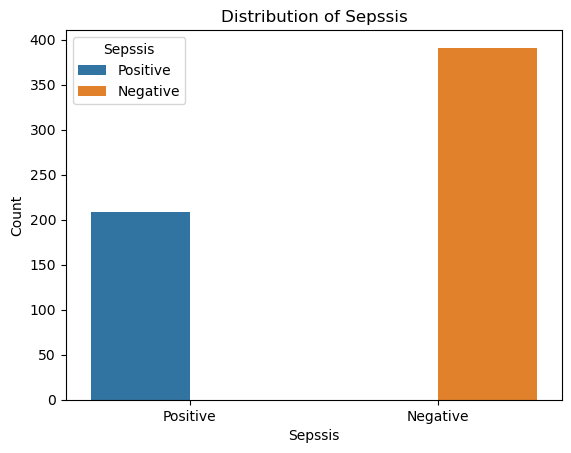

In [12]:
# Class distribution for the 'Sepssis' target variable
sns.countplot(data=df_train, x='Sepssis', hue='Sepssis')
plt.title('Distribution of Sepssis')
plt.xlabel('Sepssis')
plt.ylabel('Count')
plt.show()

It will help you understand the balance or imbalance in your dataset, which is crucial for building a predictive model. An imbalanced dataset may require special handling, such as resampling techniques

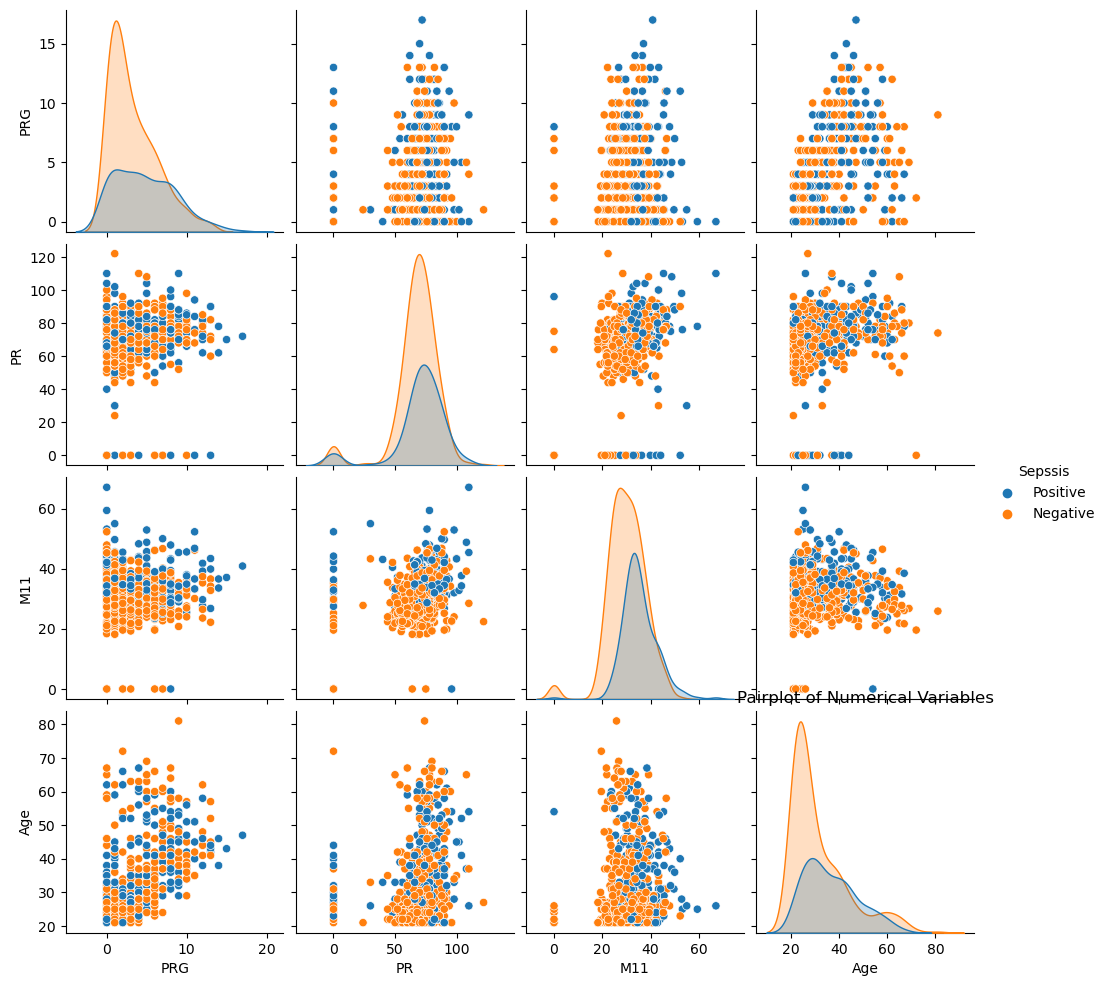

In [13]:
# Pairplot to visualize relationships between numerical variables
sns.pairplot(df_train, hue='Sepssis', vars=['PRG', 'PR', 'M11', 'Age'])
plt.title('Pairplot of Numerical Variables')
plt.show()

It will allow you to visually explore relationships and patterns between these numerical features and how they relate to the target variable.
You can identify if there are any clear separations or clusters of data points for the different 'Sepsis' classes.

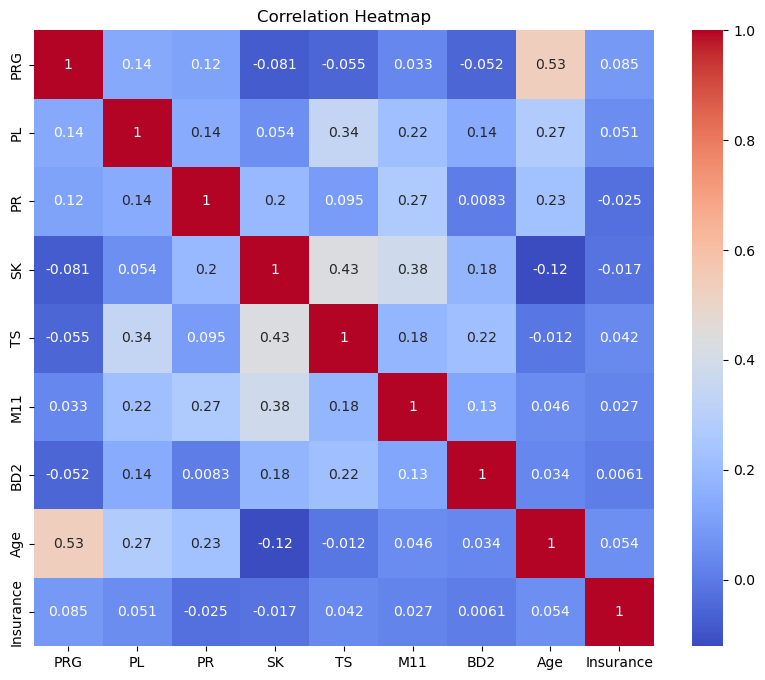

In [14]:
# Correlation heatmap for numerical variables
correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

This heatmap will help you identify potential multicollinearity (high correlation between independent variables), which can impact the performance of certain machine learning models.
Variables with strong positive or negative correlations with 'Sepsis' may be important predictors.

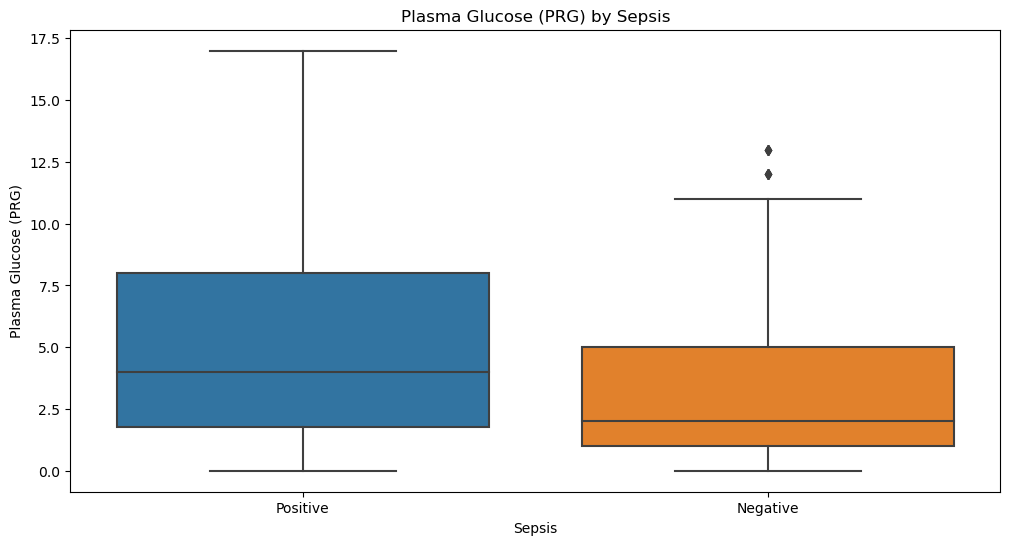

In [15]:
# Box plots for numerical variables by 'Sepsis'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sepssis', y='PRG', data=df_train)
plt.title('Plasma Glucose (PRG) by Sepsis')
plt.xlabel('Sepsis')
plt.ylabel('Plasma Glucose (PRG)')
plt.show()

It will help you assess if there are significant differences in 'Plasma Glucose' levels between patients who develop sepsis and those who do not.
Outliers and variations in the distribution can provide insights into potential risk factors.

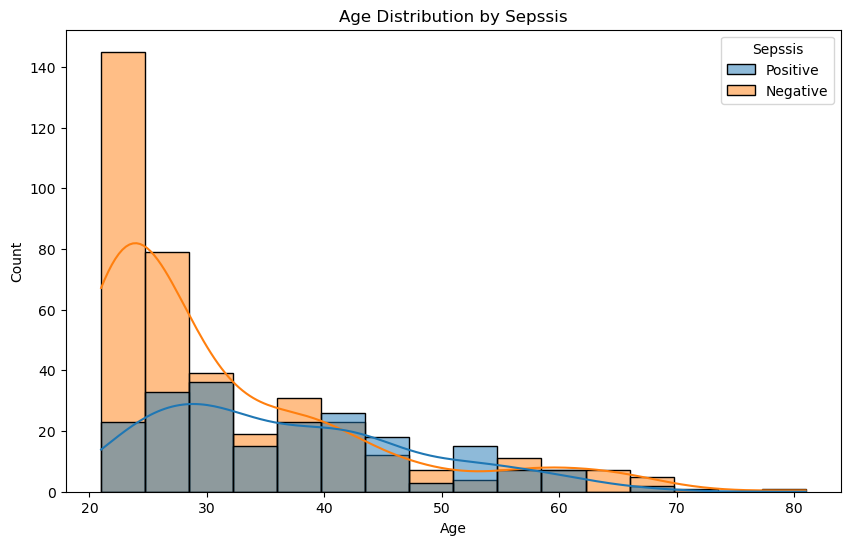

In [16]:
# Histograms for age distribution by 'Sepsis'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='Age', hue='Sepssis', kde=True)
plt.title('Age Distribution by Sepssis')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

This visualization will help you understand how age is distributed among patients with and without sepsis.
It can reveal if there are age-related trends or patterns in sepsis cases.

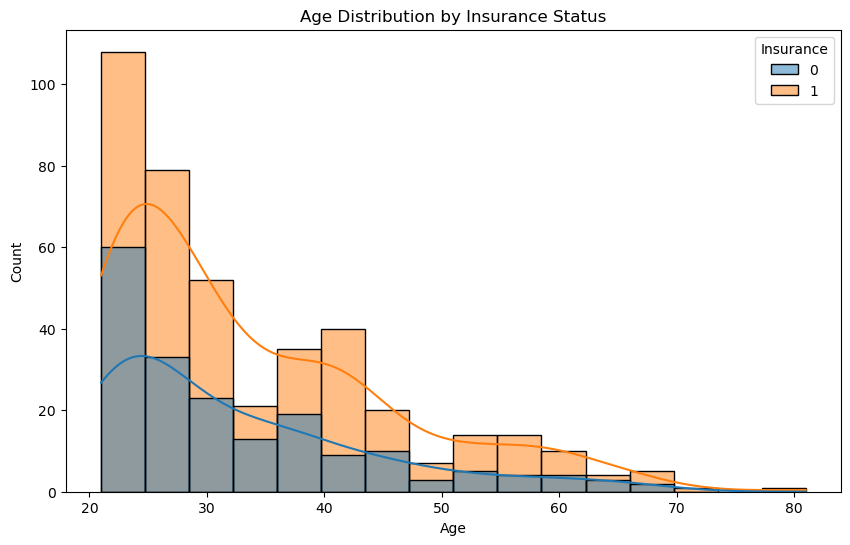

In [17]:
# Example for age distribution by 'Insurance'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='Age', hue='Insurance', kde=True)
plt.title('Age Distribution by Insurance Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


In [18]:
# Define age groups
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

# Create a new column 'AgeGroup' based on age bins
df_train['AgeGroup'] = pd.cut(df_train['Age'], bins=age_bins, labels=age_labels)

# Print the age distribution by 'Insurance' and 'AgeGroup'
age_group_by_insurance = df_train.groupby(['Insurance', 'AgeGroup']).size().unstack().fillna(0)
print("Age Distribution by Insurance Status and Age Group:")
print(age_group_by_insurance)


Age Distribution by Insurance Status and Age Group:
AgeGroup   0-19  20-29  30-39  40-49  50-59  60-69  70-79  80-89  90+
Insurance                                                            
0             0    106     43     21     12      6      0      0    0
1             0    217     85     60     33     14      1      1    0


The age distribution of patients in two categories: those with insurance (1) and those without insurance (0).
Age groups are divided into several categories, such as 0-19, 20-29, 30-39, and so on.

Interpretation:

In the "Insurance 0" row, you can see the count of uninsured patients in each age group. For example, there are 106 uninsured patients in the age group 20-29.
In the "Insurance 1" row, you can see the count of insured patients in each age group. For instance, there are 217 insured patients in the age group 20-29.
Key Insights:

This table allows us to observe the distribution of patients across different age groups for both insured and uninsured individuals.
It highlights that more patients in the 20-29 age group have insurance compared to other age groups.
Conversely, in the uninsured category, there are fewer patients in the older age groups (70-79, 80-89, 90+) compared to the insured group.

In [19]:
# Target Variable distribution by percentage
100*df_train['Sepssis'].value_counts()/len(df_train['Sepssis'])

Negative    65.275459
Positive    34.724541
Name: Sepssis, dtype: float64

In [20]:
df_train['Sepssis'].value_counts()

Negative    391
Positive    208
Name: Sepssis, dtype: int64

* Data is highly imbalanced, ratio=65:35

In [21]:
# Create a NumPy array to represent the target variable
target = np.where(df_train['Sepssis'] == 'Positive', 1, 0)

# Assign the new NumPy array to the 'Churn' column
df_train['Sepssis'] = target

# Verify the conversion
df_train['Sepssis'].unique 

<bound method Series.unique of 0      1
1      0
2      1
3      0
4      1
      ..
594    0
595    1
596    0
597    0
598    1
Name: Sepssis, Length: 599, dtype: int32>

In [22]:
df_train.head(10)

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,AgeGroup
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,1,40-49
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,0,30-39
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,1,30-39
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,0,20-29
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,1,30-39
5,ICU200015,5,116,74,0,0,25.6,0.201,30,1,0,20-29
6,ICU200016,3,78,50,32,88,31.0,0.248,26,0,1,20-29
7,ICU200017,10,115,0,0,0,35.3,0.134,29,1,0,20-29
8,ICU200018,2,197,70,45,543,30.5,0.158,53,1,1,50-59
9,ICU200019,8,125,96,0,0,0.0,0.232,54,1,1,50-59


## Questions

### 1. Is there a difference in plasma glucose levels (PRG) between patients with and without sepsis?


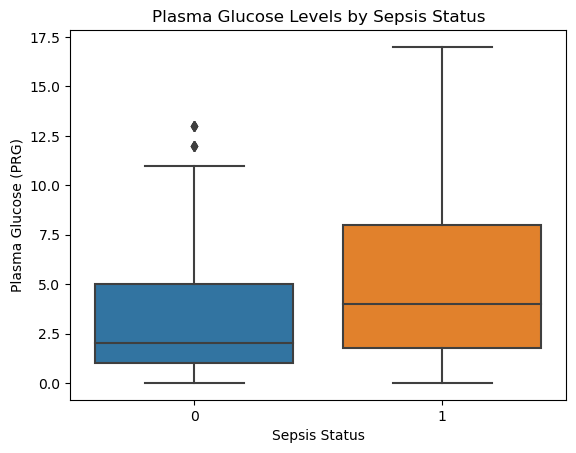

In [23]:
# Create a box plot to visualize the difference in PRG by sepsis status
sns.boxplot(data=df_train, x='Sepssis', y='PRG')
plt.title('Plasma Glucose Levels by Sepsis Status')
plt.xlabel('Sepsis Status')
plt.ylabel('Plasma Glucose (PRG)')
plt.show()

The box plot compares the distribution of plasma glucose levels (PRG) between patients with sepsis (1) and without sepsis (0). It helps answer whether there is a noticeable difference in PRG between the two groups, which could be relevant for understanding the role of PRG in sepsis.

### 2. How does age vary between patients with and without sepsis?

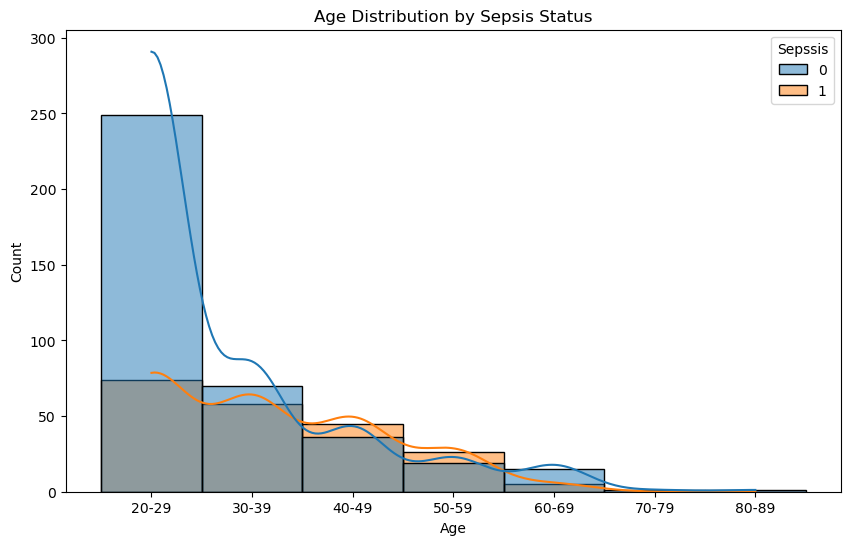

In [24]:
# Create histograms to compare the age distribution of sepsis and non-sepsis patients
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x='AgeGroup', hue='Sepssis', kde=True)
plt.title('Age Distribution by Sepsis Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


The histogram visualization of age distribution compares patients with sepsis (1) and those without sepsis (0). It allows us to see how age is distributed among these groups and assess if there are age-related patterns in sepsis incidence.

### 3. Are there differences in blood pressure (PR) between insured and uninsured patients?

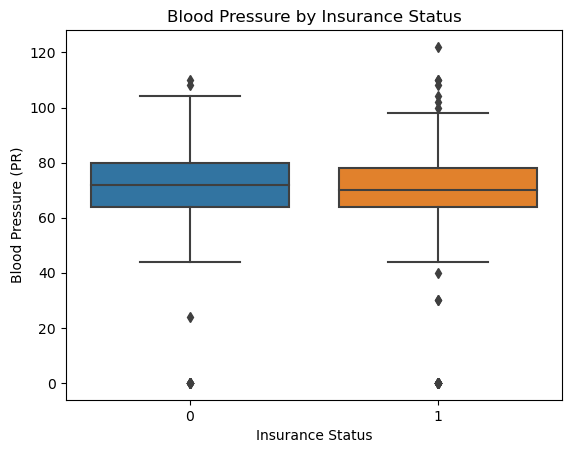

In [25]:
# Create a box plot to visualize the difference in blood pressure by insurance status
sns.boxplot(data=df_train, x='Insurance', y='PR')
plt.title('Blood Pressure by Insurance Status')
plt.xlabel('Insurance Status')
plt.ylabel('Blood Pressure (PR)')
plt.show()

The box plot shows the distribution of blood pressure (PR) among insured (1) and uninsured (0) patients. It helps us determine if there are significant differences in blood pressure between these two insurance groups.

### 4.  Is there an association between plasma glucose levels (PRG) and blood pressure (PR)?

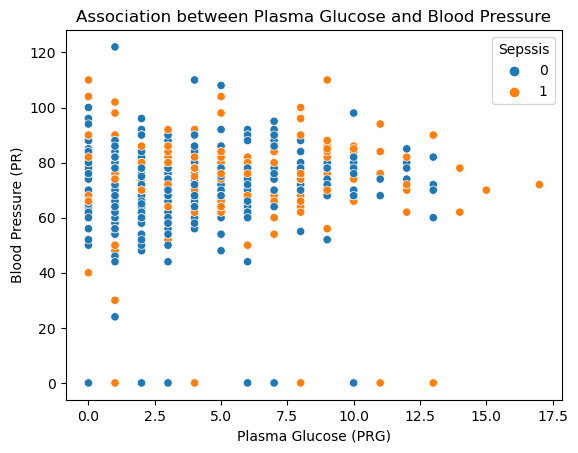

In [26]:
# Create a scatter plot to visualize the relationship between PRG and PR
sns.scatterplot(data=df_train, x='PRG', y='PR', hue='Sepssis')
plt.title('Association between Plasma Glucose and Blood Pressure')
plt.xlabel('Plasma Glucose (PRG)')
plt.ylabel('Blood Pressure (PR)')
plt.show()

The scatter plot displays the relationship between plasma glucose levels (PRG) and blood pressure (PR) for patients with sepsis (orange) and without sepsis (blue). It helps assess whether there is a correlation or pattern between these two variables.

### 5.What is the distribution of body mass index (BMI - M11) across different age groups?

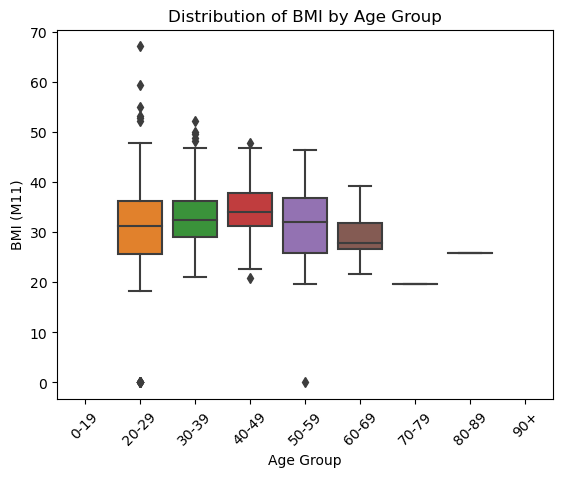

In [27]:
# Create a box plot to visualize the distribution of BMI by age group
sns.boxplot(data=df_train, x='AgeGroup', y='M11')
plt.title('Distribution of BMI by Age Group')
plt.xlabel('Age Group')
plt.ylabel('BMI (M11)')
plt.xticks(rotation=45)
plt.show()


The box plot visualizes the distribution of BMI (M11) within different age groups. It allows us to understand how BMI varies across age groups, potentially revealing age-related patterns in BMI.

### 6. How does the prevalence of sepsis vary across different age groups?

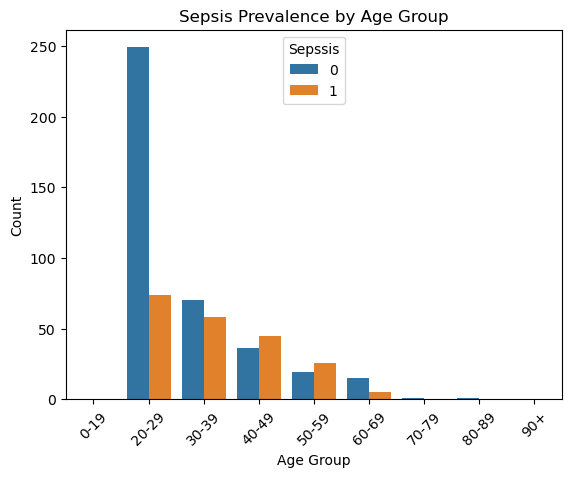

In [28]:
# Create a count plot to visualize sepsis prevalence by age group
sns.countplot(data=df_train, x='AgeGroup', hue='Sepssis')
plt.title('Sepsis Prevalence by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

The count plot illustrates the prevalence of sepsis (1) and non-sepsis (0) within various age groups. It helps us see how sepsis incidence changes with age, providing insights into age-related trends.

### 7. Are there differences in plasma glucose levels (PRG) among patients with different insurance statuses, considering their age?

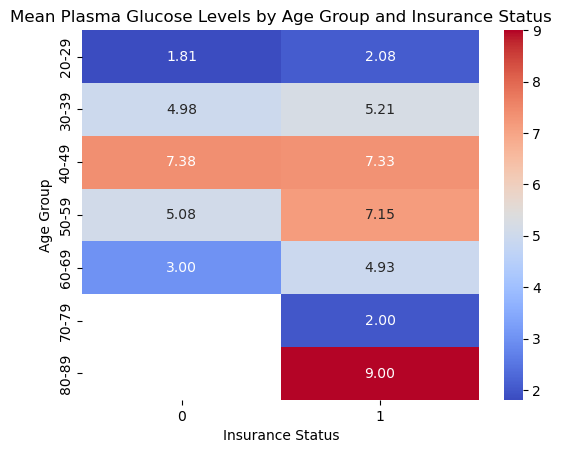

In [29]:
# Create a heatmap to visualize the mean PRG values by age group and insurance status
pivot_table = df_train.pivot_table(index='AgeGroup', columns='Insurance', values='PRG', aggfunc='mean')
sns.heatmap(pivot_table, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Mean Plasma Glucose Levels by Age Group and Insurance Status')
plt.xlabel('Insurance Status')
plt.ylabel('Age Group')
plt.show()

The heatmap displays the mean plasma glucose levels (PRG) for different age groups (rows) and insurance statuses (columns). It helps us assess whether the relationship between PRG and insurance status varies across different age groups, potentially revealing age-specific effects.

## HYPOTHESIS

### Age Distribution by Insurance Status

**Null Hypothesis (H0)**: There is no significant difference in age distribution between insured and uninsured patients.

**Alternative Hypothesis (H1)**: There is a significant difference in age distribution between insured and uninsured patients.

In [30]:
# Age Distribution by Insurance Status
insured_age = df_train[df_train['Insurance'] == 1]['Age']
uninsured_age = df_train[df_train['Insurance'] == 0]['Age']
t_stat, p_value = stats.ttest_ind(insured_age, uninsured_age, equal_var=False)

# Set the significance level
alpha = 0.05

print(" Age Distribution by Insurance Status:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


if p_value < alpha:
    print(" There is a significant difference in age distribution between insured and uninsured patients.")
else:
    print(" There is no significant difference in age distribution between insured and uninsured patients.")

 Age Distribution by Insurance Status:
T-statistic: 1.359114005409477
P-value: 0.17491186636473033
 There is no significant difference in age distribution between insured and uninsured patients.


### Plasma Glucose Levels by Sepsis Status

**Null Hypothesis (H0)**: The mean plasma glucose levels are the same for patients with and without sepsis.

**Alternative Hypothesis (H1)**: The mean plasma glucose levels are different between patients with and without sepsis.

In [31]:
# Hypothesis 1: Plasma Glucose Levels by Sepsis Status
sepsis_group = df_train[df_train['Sepssis'] == 1]['PRG']
non_sepsis_group = df_train[df_train['Sepssis'] == 0]['PRG']
t_stat, p_value = stats.ttest_ind(sepsis_group, non_sepsis_group, equal_var=False)

# Set the significance level
alpha = 0.05

print(" Plasma Glucose Levels by Sepsis Status:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("There is a significant difference in plasma glucose levels between patients with and without sepsis.")
else:
    print(" There is no significant difference in plasma glucose levels between patients with and without sepsis.")


 Plasma Glucose Levels by Sepsis Status:
T-statistic: 4.842533902324343
P-value: 1.924247139438273e-06
There is a significant difference in plasma glucose levels between patients with and without sepsis.


### Blood Pressure by Insurance Status

**Null Hypothesis (H0)**: There is no significant difference in blood pressure between insured and uninsured patients.

**Alternative Hypothesis (H1)**: There is a significant difference in blood pressure between insured and uninsured patients.

In [32]:
# Hypothesis 2: Blood Pressure by Insurance Status
insured_group = df_train[df_train['Insurance'] == 1]['PR']
uninsured_group = df_train[df_train['Insurance'] == 0]['PR']
t_stat, p_value = stats.ttest_ind(insured_group, uninsured_group, equal_var=False)
print(" Blood Pressure by Insurance Status:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


# Set the significance level
alpha = 0.05

if p_value < alpha:
    print("There is a significant difference in blood pressure between insured and uninsured patients.")
else:
    print("There is no significant difference in blood pressure between insured and uninsured patients.")


 Blood Pressure by Insurance Status:
T-statistic: -0.6140188592745929
P-value: 0.539596953434826
There is no significant difference in blood pressure between insured and uninsured patients.


### Age Distribution by Sepsis Status

**Null Hypothesis (H0)**: The age distributions are the same for patients with and without sepsis.

**Alternative Hypothesis (H1)**: The age distributions are different between patients with and without sepsis.

In [33]:
# Hypothesis 3: Age Distribution by Sepsis Status (Kolmogorov-Smirnov test)
sepsis_age = df_train[df_train['Sepssis'] == 1]['Age']
non_sepsis_age = df_train[df_train['Sepssis'] == 0]['Age']
ks_stat, p_value = stats.ks_2samp(sepsis_age, non_sepsis_age)
print("Age Distribution by Sepsis Status:")
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.05

if p_value < alpha:
    print("The age distribution differs significantly between patients with and without sepsis.")
else:
    print("There is no significant difference in age distribution between patients with and without sepsis.")


Age Distribution by Sepsis Status:
KS Statistic: 0.31081546330906945
P-value: 4.148871074130695e-12
The age distribution differs significantly between patients with and without sepsis.


### BMI by Insurance Status

**Null Hypothesis (H0)**: There is no significant difference in BMI between insured and uninsured patients.

**Alternative Hypothesis (H1)**: There is a significant difference in BMI between insured and uninsured patients.

In [34]:
# Hypothesis 4: BMI by Insurance Status (Using Mann-Whitney U Test)
insured_bmi = df_train[df_train['Insurance'] == 1]['M11']
uninsured_bmi = df_train[df_train['Insurance'] == 0]['M11']
u_stat, p_value = stats.mannwhitneyu(insured_bmi, uninsured_bmi, alternative='two-sided')
print("BMI by Insurance Status (Mann-Whitney U Test):")
print(f"U-statistic: {u_stat}")
print(f"P-value: {p_value}")

# Set the significance level
alpha = 0.05

# Hypothesis 4: BMI by Insurance Status
if p_value < alpha:
    print(" There is a significant difference in BMI between insured and uninsured patients.")
else:
    print("There is no significant difference in BMI between insured and uninsured patients.")


BMI by Insurance Status (Mann-Whitney U Test):
U-statistic: 39643.0
P-value: 0.6078793786433843
There is no significant difference in BMI between insured and uninsured patients.


## Feature Processing & Engineering

* This includes Dropping missing values and other feature important processes 

In [35]:
df_train.head()

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis,AgeGroup
0,ICU200010,6,148,72,35,0,33.6,0.627,50,0,1,40-49
1,ICU200011,1,85,66,29,0,26.6,0.351,31,0,0,30-39
2,ICU200012,8,183,64,0,0,23.3,0.672,32,1,1,30-39
3,ICU200013,1,89,66,23,94,28.1,0.167,21,1,0,20-29
4,ICU200014,0,137,40,35,168,43.1,2.288,33,1,1,30-39


In [36]:
df_train.drop(["ID", "AgeGroup"], axis=1, inplace=True)

In [37]:
df_train

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance,Sepssis
0,6,148,72,35,0,33.6,0.627,50,0,1
1,1,85,66,29,0,26.6,0.351,31,0,0
2,8,183,64,0,0,23.3,0.672,32,1,1
3,1,89,66,23,94,28.1,0.167,21,1,0
4,0,137,40,35,168,43.1,2.288,33,1,1
...,...,...,...,...,...,...,...,...,...,...
594,6,123,72,45,230,33.6,0.733,34,0,0
595,0,188,82,14,185,32.0,0.682,22,1,1
596,0,67,76,0,0,45.3,0.194,46,1,0
597,1,89,24,19,25,27.8,0.559,21,0,0


In [38]:
Numerical = ['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2','Age','Insurance']

In [39]:
df_train.dtypes

PRG            int64
PL             int64
PR             int64
SK             int64
TS             int64
M11          float64
BD2          float64
Age            int64
Insurance      int64
Sepssis        int32
dtype: object

## Data Splitting 

In [41]:
X = df_train.drop(columns = "Sepssis")
y = df_train["Sepssis"].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify =y)

In [43]:
print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)

Training set size: (479, 9) (479,)
Testing set size: (120, 9) (120,)


## Impute Missing Values

In [45]:
# Create a SimpleImputer for numerical features
numerical_imputer = SimpleImputer(strategy='mean')  
# Fit and transform the imputer on your training data
X_train_imputer = numerical_imputer.fit_transform(X_train[Numerical])

# Transform the imputer on your test data (without fitting to avoid data leakage)
X_test_imputer = numerical_imputer.transform(X_test[Numerical])


In [46]:
print(Numerical)

['PRG', 'PL', 'PR', 'SK', 'TS', 'M11', 'BD2', 'Age', 'Insurance']


## Feature Scaling

In [49]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit and transform the numeric variables in the training set
X_train_scaled = X_train.copy()  # Create a copy of X_train_encoding
X_train_scaled[Numerical] = scaler.fit_transform(X_train_scaled[Numerical])

# Transform the numeric variables in the testing set using the fitted scaler
X_test_scaled = X_test.copy()  # Create a copy of X_test_encoding
X_test_scaled[Numerical] = scaler.transform(X_test_scaled[Numerical])

# Create a DataFrame to hold the scaled data
scaled = pd.concat([X_train_scaled, X_test_scaled])

In [50]:
# Concatenate the encoded & scaled training and testing sets
X_encode = pd.concat([X_train_scaled, X_test_scaled], axis=0)

In [51]:
X_train_scaled.shape

(479, 9)

In [52]:
X_test_scaled.shape

(120, 9)

In [53]:
X_encode

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
161,0.936259,-0.541760,0.292468,1.227874,0.278949,0.706624,-0.824511,0.991413,0.678503
236,0.936259,1.923458,0.812484,0.025886,1.108512,0.534049,0.260234,1.504619,-1.473834
497,-0.563634,-1.197071,0.188465,-0.353689,0.002429,-0.235902,0.149488,-0.719274,0.678503
40,-0.263656,1.892252,-0.227548,0.278936,-0.054783,0.281824,-0.634255,-0.633740,-1.473834
372,-1.163592,-1.103456,-0.227548,0.089149,-0.092923,0.520774,0.143808,-1.061412,0.678503
...,...,...,...,...,...,...,...,...,...
517,0.936259,0.175961,0.916487,-1.302627,-0.722247,0.759724,-0.540547,1.504619,0.678503
94,-0.563634,0.706451,0.708481,-0.163901,-0.111994,-0.952752,0.757172,-1.061412,0.678503
496,0.336302,-0.292118,-0.019541,-1.302627,-0.722247,-0.780177,-0.574623,-0.291603,-1.473834
582,2.436153,0.051140,0.500474,-0.227164,-0.722247,-0.713802,-0.668331,2.445497,0.678503


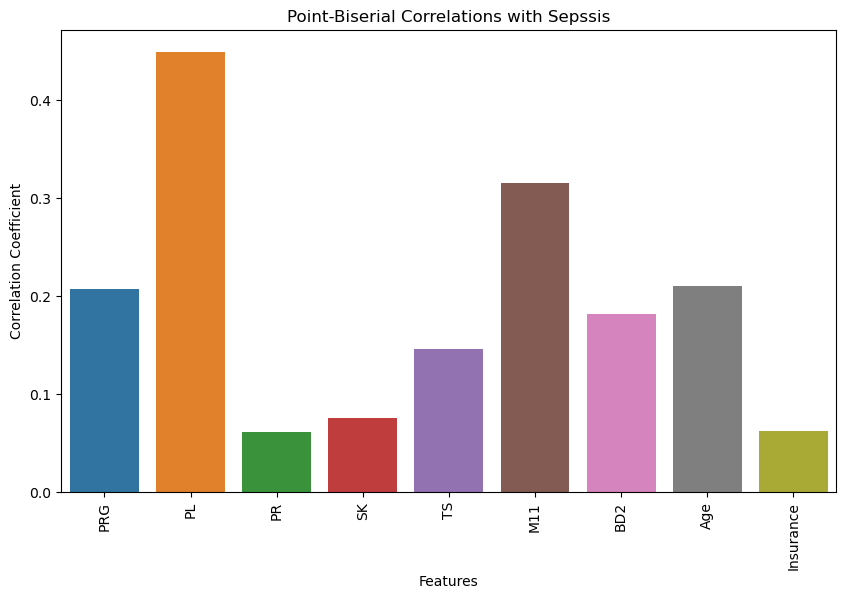

In [54]:
# Convert X_encode and y to DataFrames
X_encode_df = pd.DataFrame(X_encode, columns=X_encode.columns)
y_df = pd.DataFrame(y, columns=['Sepssis'])

# Combine X_encode_df with y_df
encoded_data = pd.concat([X_encode_df, y_df], axis=1)

# Calculate point-biserial correlations
correlations = encoded_data.corr()['Sepssis'].drop('Sepssis')  # Drop Sepssis itself from correlations

# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Point-Biserial Correlations with Sepssis')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.show()

Positive correlation (above 0.0): This means that higher values of these numerical features are associated with a higher likelihood or probability of the target variable Sepssis being 1 (positive or present). In other words, an increase in the value of each of these numerical features is associated with an increased chance of sepsis.

- **PL (Blood Work Result-1)** had the highest positive correlation, with a coefficient above 0.4. This indicates a strong positive association between the "PL" feature and the likelihood of sepsis. Higher values of "PL" are strongly correlated with a higher probability of sepsis.

- **M11 (Body Mass Index)** had a positive correlation, though slightly lower than "PL." This suggests that higher values of BMI (M11) are associated with an increased likelihood of sepsis.

- **Age** had a positive correlation, though the coefficient was lower than "PL" and "M11." This implies that older age is associated with a somewhat increased likelihood of sepsis.

- **PR (Blood Pressure)** had the lowest positive correlation but was still above 0.0. This indicates a relatively weaker positive association between blood pressure (PR) and sepsis compared to the other features.

Overall, these correlation coefficients provide insights into how each of these numerical features relates to the occurrence of sepsis. "PL" appears to have the strongest positive relationship, while "PR" has a weaker positive relationship. Keep in mind that correlation does not imply causation, and further analysis and modeling are needed to understand the predictive power and significance of these features in the context of our machine learning model.

The "AgeGroup_20-29" has a higher overall prevalence of sepsis cases (both positive and negative) compared to other age groups, it can affect the correlation coefficient. The correlation coefficient measures the linear relationship between two variables, and if there is a high prevalence of sepsis in a particular category (age group in this case), it can impact the direction and magnitude of the correlation.

In this context, it's important to keep in mind that correlation does not imply causation. A lower correlation coefficient for a specific category doesn't necessarily mean that being in that category directly causes a decrease in sepsis risk.

## Train Set Balancing

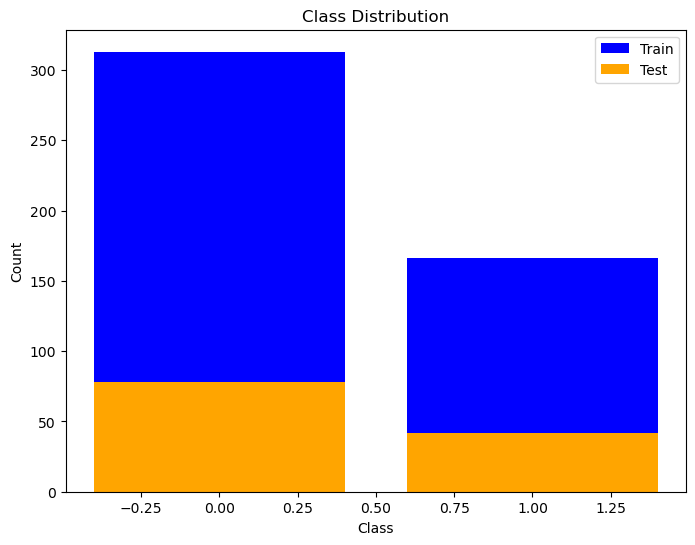

In [55]:
# Convert y_train and y_test to Pandas Series
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Count the number of samples in each class in the training set
train_class_counts = y_train_series.value_counts()

# Count the number of samples in each class in the testing set
test_class_counts = y_test_series.value_counts()

plt.figure(figsize=(8, 6))
plt.bar(train_class_counts.index, train_class_counts.values, color='blue', label='Train')
plt.bar(test_class_counts.index, test_class_counts.values, color='orange', label='Test')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.legend()
plt.show()

In [56]:
train_churn_count = pd.Series(y_train).value_counts()
test_churn_count = pd.Series(y_test).value_counts()

print("Sepssis count in y_train:")
print(train_churn_count)

print("\nSepssis count in y_test:")
print(test_churn_count)

Sepssis count in y_train:
0    313
1    166
dtype: int64

Sepssis count in y_test:
0    78
1    42
dtype: int64


The class count for the target variable "Sepssis" in both the training and test datasets can be briefly described as follows:

In the training dataset:
- Class 0 (indicating the absence of sepsis) appears 313 times.
- Class 1 (indicating the presence of sepsis) appears 166 times.

In the test dataset:
- Class 0 appears 78 times.
- Class 1 appears 42 times.

This description provides a summary of the distribution of sepsis and non-sepsis cases in both the training and test datasets, which is essential information for understanding the class balance and potential class imbalance in your data.

In [57]:
# Instantiate the SMOTE object
smote = SMOTE(random_state=42) 

# Apply SMOTE to balance the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Convert y_train_resampled to a Pandas Series for value_counts
y_train_balanced = pd.Series(y_train_balanced)

# Check the class distribution after applying SMOTE
print("Class distribution after SMOTE:")
print(y_train_balanced.value_counts())


Class distribution after SMOTE:
0    313
1    313
dtype: int64


## Train & Evaluate Models

In [58]:
# Define the calculate_metrics function
def calculate_metrics(y_true, y_pred):
    metrics = {}
    metrics['f1_score'] = f1_score(y_true, y_pred)
    return metrics

In [59]:
# Initialize the models
models = [
    AdaBoostClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    xgb.XGBClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    lgb.LGBMClassifier(random_state=4, n_estimators=100, learning_rate=0.1),
    catboost.CatBoostClassifier(random_state=4, verbose=0, iterations=100)
]

In [60]:
model_names = [
    'AdaBoost',
    'XGBoost',
    'LightGBM',
    'CatBoost'
]

In [61]:
leaderboard_imbalanced = {}

for model, name in zip(models, model_names):
    # Convert data to NumPy arrays and ensure they are in the correct order
    X_train_scaled_np = np.ascontiguousarray(X_train_scaled.values)
    y_train_np = np.ascontiguousarray(y_train)
    X_test_scaled_np = np.ascontiguousarray(X_test_scaled.values)
    
    model.fit(X_train_scaled_np, y_train_np)
    y_pred = model.predict(X_test_scaled_np)
    metrics = calculate_metrics(y_test, y_pred)
    leaderboard_imbalanced[name] = metrics
    
    # Print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['No', 'Yes']))
    print()

# Create a DataFrame from the leaderboard dictionary
leaderboard_df = pd.DataFrame(leaderboard_imbalanced).transpose()

# Format the F1-score column to display with two decimal places
leaderboard_df['Imbalanced Data F1-score'] = leaderboard_df['f1_score'].map('{:.2f}'.format)

leaderboard_df.sort_values(by='Imbalanced Data F1-score', ascending=False, inplace=True)

leaderboard_df.index.name = 'Models'
leaderboard_df.reset_index(inplace=True)

print("Leaderboard: Imbalanced Data")
leaderboard_df.drop('f1_score', axis=1, inplace=True)
leaderboard_df

Classification Report for AdaBoost:
              precision    recall  f1-score   support

          No       0.78      0.82      0.80        78
         Yes       0.63      0.57      0.60        42

    accuracy                           0.73       120
   macro avg       0.71      0.70      0.70       120
weighted avg       0.73      0.73      0.73       120


Classification Report for XGBoost:
              precision    recall  f1-score   support

          No       0.76      0.78      0.77        78
         Yes       0.57      0.55      0.56        42

    accuracy                           0.70       120
   macro avg       0.67      0.66      0.67       120
weighted avg       0.70      0.70      0.70       120


[LightGBM] [Info] Number of positive: 166, number of negative: 313
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 575
[LightGB

Classification Report for CatBoost:
              precision    recall  f1-score   support

          No       0.77      0.79      0.78        78
         Yes       0.59      0.55      0.57        42

    accuracy                           0.71       120
   macro avg       0.68      0.67      0.67       120
weighted avg       0.70      0.71      0.71       120


Leaderboard: Imbalanced Data


,Models,Imbalanced Data F1-score
0,LightGBM,0.61
1,AdaBoost,0.60
2,CatBoost,0.57
3,XGBoost,0.56


In [62]:
leaderboard_balanced = {}

for model, name in zip(models, model_names):
    model.fit(X_train_balanced, y_train_balanced)
    
    # Convert X_test_encoded to a NumPy array and ensure it's in the correct order
    X_test_scaled_np = np.ascontiguousarray(X_test_scaled)
    
    y_pred = model.predict(X_test_scaled_np)
    metrics = calculate_metrics(y_test, y_pred)
    leaderboard_balanced[name] = metrics
    
    # Print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['No', 'Yes']))
    print()

# Create a DataFrame from the leaderboard dictionary
leaderboard_df1 = pd.DataFrame(leaderboard_balanced).transpose()

# Format the F1-score column to display with two decimal places
leaderboard_df1['Balanced Data F1-score'] = leaderboard_df1['f1_score'].map('{:.2f}'.format)

# Sort the DataFrame by F1-score in descending order
leaderboard_df1.sort_values(by='Balanced Data F1-score', ascending=False, inplace=True)

leaderboard_df1.index.name = 'Models'
leaderboard_df1.reset_index(inplace=True)

print("Leaderboard: Balanced Data")
leaderboard_df1.drop('f1_score', axis=1, inplace=True)
leaderboard_df1


Classification Report for AdaBoost:
              precision    recall  f1-score   support

          No       0.87      0.76      0.81        78
         Yes       0.63      0.79      0.70        42

    accuracy                           0.77       120
   macro avg       0.75      0.77      0.76       120
weighted avg       0.79      0.77      0.77       120


Classification Report for XGBoost:
              precision    recall  f1-score   support

          No       0.79      0.69      0.74        78
         Yes       0.54      0.67      0.60        42

    accuracy                           0.68       120
   macro avg       0.67      0.68      0.67       120
weighted avg       0.70      0.68      0.69       120


[LightGBM] [Info] Number of positive: 313, number of negative: 313
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGB

Classification Report for CatBoost:
              precision    recall  f1-score   support

          No       0.79      0.69      0.74        78
         Yes       0.54      0.67      0.60        42

    accuracy                           0.68       120
   macro avg       0.67      0.68      0.67       120
weighted avg       0.70      0.68      0.69       120


Leaderboard: Balanced Data


,Models,Balanced Data F1-score
0,AdaBoost,0.70
1,XGBoost,0.60
2,CatBoost,0.60
3,LightGBM,0.55


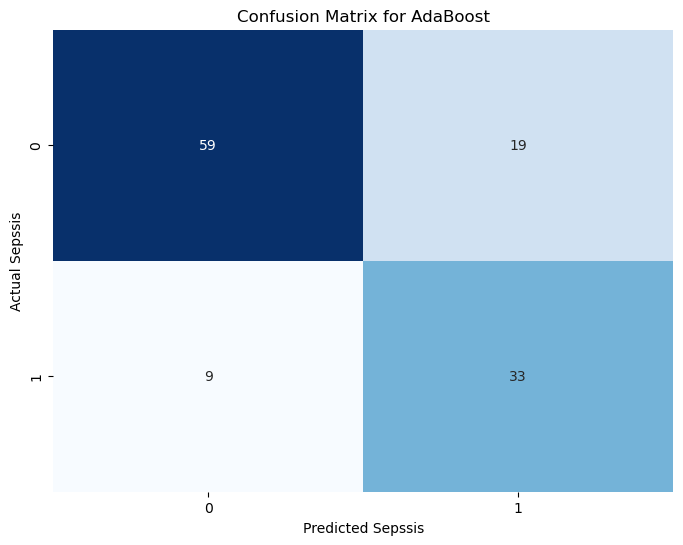

Confusion Matrix for AdaBoost:
[[59 19]
 [ 9 33]]



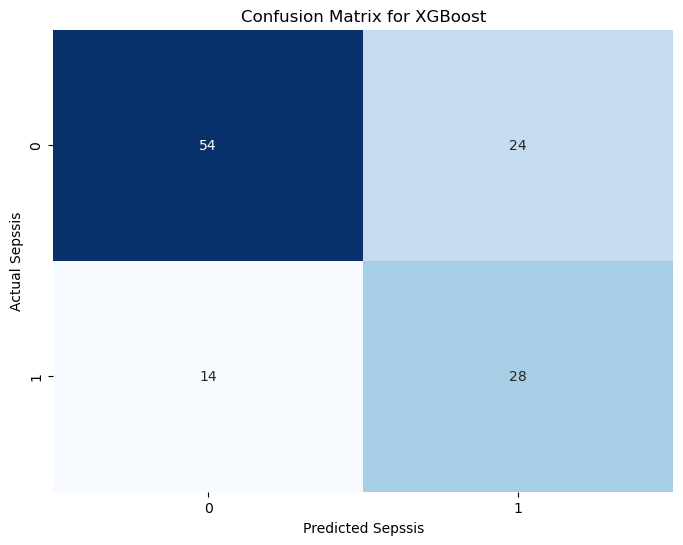

Confusion Matrix for XGBoost:
[[54 24]
 [14 28]]

[LightGBM] [Info] Number of positive: 313, number of negative: 313
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 626, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

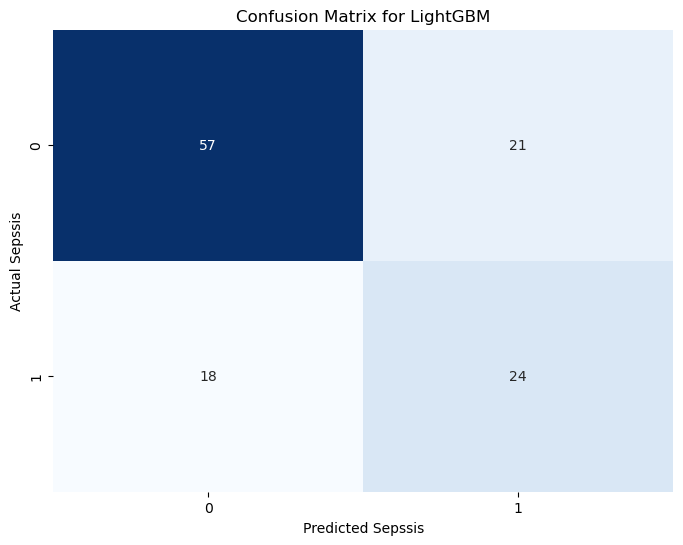

Confusion Matrix for LightGBM:
[[57 21]
 [18 24]]



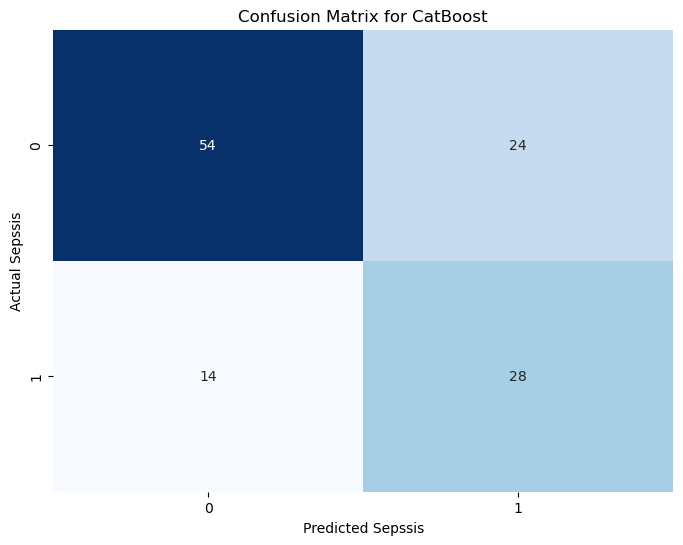

Confusion Matrix for CatBoost:
[[54 24]
 [14 28]]



In [63]:
for model, name in zip(models, model_names):
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test_scaled)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Sepssis")
    plt.ylabel("Actual Sepssis")
    plt.show()
    
    print(f"Confusion Matrix for {name}:")
    print(cm)
    print()

The confusion matrix is a fundamental evaluation metric used in binary classification to understand how well a machine learning model is performing. It presents a clear breakdown of predictions made by the model. Let's break down the numbers in the confusion matrix you provided:

In our confusion matrix for the AdaBoost model:

- True Positive (TP): 33
  - This represents the number of instances where the model correctly predicted "Yes" (positive class) when the actual class was also "Yes."

- False Positive (FP): 19
  - This represents the number of instances where the model incorrectly predicted "Yes" when the actual class was "No."

- True Negative (TN): 59
  - This represents the number of instances where the model correctly predicted "No" (negative class) when the actual class was also "No."

- False Negative (FN): 9
  - This represents the number of instances where the model incorrectly predicted "No" when the actual class was "Yes."

## Hyperparameter Tuning

In [64]:
# Define a function for hyperparameter tuning specifically for AdaBoost
def tune_adaboost(X_train_balanced, y_train_balanced, X_test_scaled, y_test):
    param_grid = {
        'n_estimators': [1200],
        'learning_rate': [0.1, 0.05, 0.01, 0.001]
    }

    ada_model = AdaBoostClassifier(random_state=4)
    grid_search = GridSearchCV(ada_model, param_grid, scoring='f1', cv=5, verbose=3, refit=True)
    grid_search.fit(X_train_balanced, y_train_balanced)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_pred = best_model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    return best_model, best_params, f1

In [65]:

# Perform hyperparameter tuning for AdaBoost
best_model, best_params, ada_f1 = tune_adaboost(X_train_balanced, y_train_balanced, X_test_scaled, y_test)

print("Best parameters for AdaBoost:", best_params)
print("Tuned F1-score for AdaBoost:", ada_f1)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END learning_rate=0.1, n_estimators=1200;, score=0.744 total time=   7.4s
[CV 2/5] END learning_rate=0.1, n_estimators=1200;, score=0.640 total time=   7.1s
[CV 3/5] END learning_rate=0.1, n_estimators=1200;, score=0.803 total time=   6.5s
[CV 4/5] END learning_rate=0.1, n_estimators=1200;, score=0.842 total time=   6.8s
[CV 5/5] END learning_rate=0.1, n_estimators=1200;, score=0.855 total time=   6.2s
[CV 1/5] END learning_rate=0.05, n_estimators=1200;, score=0.740 total time=   7.2s
[CV 2/5] END learning_rate=0.05, n_estimators=1200;, score=0.651 total time=   7.1s
[CV 3/5] END learning_rate=0.05, n_estimators=1200;, score=0.810 total time=   7.1s
[CV 4/5] END learning_rate=0.05, n_estimators=1200;, score=0.842 total time=  10.0s
[CV 5/5] END learning_rate=0.05, n_estimators=1200;, score=0.843 total time=  11.4s
[CV 1/5] END learning_rate=0.01, n_estimators=1200;, score=0.772 total time=  10.3s
[CV 2/5] END learning

In [66]:
print(best_model)

AdaBoostClassifier(learning_rate=0.01, n_estimators=1200, random_state=4)


* The Adaboost model maintained it performance after a series of hyperparameter tuning.

## Export Key Component

In [67]:
# Create a dictionary to store the exported variables
exported_data = {
    'numerical_imputer': numerical_imputer,
    'scaler': scaler,
    'best_model': best_model
}

In [68]:
# Create a folder to store the exported data
folder_name = 'exported_comp_folder'
os.makedirs(folder_name, exist_ok=True)

In [69]:
# Export the variables
exported_data_path = os.path.join(folder_name, 'sepssis_components.pkl')
with open(exported_data_path, 'wb') as file:
    pickle.dump(exported_data, file)

In [70]:
# Generate the requirements.txt file
!pip freeze > exported_comp_folder/requirements.txt

In [71]:
# Zip the exported_data folder
shutil.make_archive('exported_data', 'zip', 'exported_comp_folder')

print("Exported data has been zipped.")

Exported data has been zipped.


## Test Prediction

In [72]:
exported_data_path = 'exported_comp_folder/sepssis_components.pkl'
with open(exported_data_path, 'rb') as file:
    exported_data = pickle.load(file)

In [73]:
# categorical_imputer = exported_data['categorical_imputer']
numerical_imputer = exported_data['numerical_imputer']
# encoder = exported_data['encoder']
scaler = exported_data['scaler']
best_model = exported_data['best_model']

In [74]:
# Load the Raw Prediction Data
test_df = pd.read_csv('Asset\Paitients_Files_Test.csv')

In [75]:
test_df

,ID,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,ICU200609,1,109,38,18,120,23.1,0.407,26,1
1,ICU200610,1,108,88,19,0,27.1,0.400,24,1
2,ICU200611,6,96,0,0,0,23.7,0.190,28,1
3,ICU200612,1,124,74,36,0,27.8,0.100,30,1
4,ICU200613,7,150,78,29,126,35.2,0.692,54,0
...,...,...,...,...,...,...,...,...,...,...
164,ICU200773,10,101,76,48,180,32.9,0.171,63,1
165,ICU200774,2,122,70,27,0,36.8,0.340,27,1
166,ICU200775,5,121,72,23,112,26.2,0.245,30,1
167,ICU200776,1,126,60,0,0,30.1,0.349,47,1


In [76]:
ids = test_df['ID'].copy()

In [77]:
test_df.drop('ID', axis=1, inplace=True)

In [78]:
test_df.dtypes

PRG            int64
PL             int64
PR             int64
SK             int64
TS             int64
M11          float64
BD2          float64
Age            int64
Insurance      int64
dtype: object

In [79]:
test_df

,PRG,PL,PR,SK,TS,M11,BD2,Age,Insurance
0,1,109,38,18,120,23.1,0.407,26,1
1,1,108,88,19,0,27.1,0.400,24,1
2,6,96,0,0,0,23.7,0.190,28,1
3,1,124,74,36,0,27.8,0.100,30,1
4,7,150,78,29,126,35.2,0.692,54,0
...,...,...,...,...,...,...,...,...,...
164,10,101,76,48,180,32.9,0.171,63,1
165,2,122,70,27,0,36.8,0.340,27,1
166,5,121,72,23,112,26.2,0.245,30,1
167,1,126,60,0,0,30.1,0.349,47,1


In [80]:
# Preprocessing for numerical data
prediction_data_numerical = test_df.select_dtypes(include=['int', 'float'])

# Apply imputation to numerical data
prediction_data_numerical_imputed = numerical_imputer.transform(prediction_data_numerical)

# Apply scaling to numerical data
prediction_data_scaled = scaler.transform(prediction_data_numerical_imputed)

# Convert the scaled numerical data to a DataFrame
prediction_data_scaled_df = pd.DataFrame(prediction_data_scaled,
                                         columns=prediction_data_numerical.columns,
                                         index=prediction_data_numerical.index)

# Perform Predictions
predictions = best_model.predict(prediction_data_scaled_df)

# DataFrame for Predictions
prediction_results = pd.DataFrame({'ID': ids, 'Sepssis predictions': predictions})


In [81]:
# DataFrame for Predictions
prediction_results = pd.DataFrame({'ID': ids, 'Sepssis predictions': predictions})

In [82]:
# Map predictions to "Positive" and "Negative"
prediction_results['Sepssis predictions'] = prediction_results['Sepssis predictions'].map({1: 'Positive', 0: 'Negative'})

In [83]:
prediction_results

,ID,Sepssis predictions
0,ICU200609,Negative
1,ICU200610,Negative
2,ICU200611,Negative
3,ICU200612,Negative
4,ICU200613,Positive
...,...,...
164,ICU200773,Negative
165,ICU200774,Positive
166,ICU200775,Negative
167,ICU200776,Positive


In [84]:
# Count the occurrences of "Positive" and "Negative" in the predictions
count = prediction_results['Sepssis predictions'].value_counts()

# Print the count
print(count)

Negative    94
Positive    75
Name: Sepssis predictions, dtype: int64


In [85]:
# Save the Predictions
prediction_results.to_csv('sepssis_prediction_results.csv', index=False)

Based on the distribution of predictions on the new unseen data:

- Negative Predictions: 94
- Positive Predictions: 75

It can be concluded that the model made predictions for both negative and positive cases of sepsis. The model identified 94 cases as negative (no sepsis) and 75 cases as positive (sepsis). which is a fairly good generalization of the model.